# SCATS Data Preprocessing
This notebook handles the loading, cleaning, reshaping, and visualizing of SCATS traffic data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load SCATS data (adjust the path if needed)
df = pd.read_csv("../Data/Scats Data October 2006.csv", skiprows=1)
df.head()

,SCATS Number,Location,CD_MELWAY,NB_LATITUDE,NB_LONGITUDE,HF VicRoads Internal,VR Internal Stat,VR Internal Loc,NB_TYPE_SURVEY,Date,...,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95
0,970,WARRIGAL_RD N of HIGH STREET_RD,060 G10,-37.86703,145.09159,249,182,1,1,10/1/2006,...,114,97,97,66,81,50,59,47,29,34
1,970,WARRIGAL_RD N of HIGH STREET_RD,060 G10,-37.86703,145.09159,249,182,1,1,10/2/2006,...,111,102,107,114,80,60,62,48,44,26
2,970,WARRIGAL_RD N of HIGH STREET_RD,060 G10,-37.86703,145.09159,249,182,1,1,10/3/2006,...,130,132,114,86,93,90,73,57,29,40
3,970,WARRIGAL_RD N of HIGH STREET_RD,060 G10,-37.86703,145.09159,249,182,1,1,10/4/2006,...,115,113,132,101,113,90,78,66,52,44
4,970,WARRIGAL_RD N of HIGH STREET_RD,060 G10,-37.86703,145.09159,249,182,1,1,10/5/2006,...,171,120,116,113,99,91,61,55,49,36


In [7]:
# Melt the time columns
time_cols = [f'V{str(i).zfill(2)}' for i in range(1, 96)]  # Up to V95
df_melted = df.melt(
    id_vars=['SCATS Number', 'Location', 'Date'],
    value_vars=time_cols,
    var_name='Interval',
    value_name='Traffic_flow'
)
df_melted.head()

,SCATS Number,Location,Date,Interval,Traffic_flow
0,970,WARRIGAL_RD N of HIGH STREET_RD,10/1/2006,V01,83
1,970,WARRIGAL_RD N of HIGH STREET_RD,10/2/2006,V01,28
2,970,WARRIGAL_RD N of HIGH STREET_RD,10/3/2006,V01,32
3,970,WARRIGAL_RD N of HIGH STREET_RD,10/4/2006,V01,22
4,970,WARRIGAL_RD N of HIGH STREET_RD,10/5/2006,V01,39


In [8]:
# Map interval to 15-min offsets
interval_time_map = {
    f'V{str(i).zfill(2)}': pd.Timedelta(minutes=15 * (i - 1))
    for i in range(1, 97)
}

df_melted['Date'] = pd.to_datetime(df_melted['Date'])
df_melted['TimeOffset'] = df_melted['Interval'].map(interval_time_map)
df_melted['Datetime'] = df_melted['Date'] + df_melted['TimeOffset']
df_melted.drop(columns=['TimeOffset', 'Date', 'Interval'], inplace=True)
df_melted = df_melted.sort_values(by=['SCATS Number', 'Datetime']).reset_index(drop=True)
df_melted.head()

,SCATS Number,Location,Traffic_flow,Datetime
0,970,WARRIGAL_RD N of HIGH STREET_RD,83,2006-10-01 00:00:00
1,970,HIGH STREET_RD E of WARRIGAL_RD,30,2006-10-01 00:00:00
2,970,WARRIGAL_RD S of HIGH STREET_RD,93,2006-10-01 00:00:00
3,970,HIGH STREET_RD W of WARRIGAL_RD,42,2006-10-01 00:00:00
4,970,WARRIGAL_RD N of HIGH STREET_RD,52,2006-10-01 00:15:00


In [9]:
df_melted[['SCATS Number', 'Location']].drop_duplicates().sort_values(by='SCATS Number')


,SCATS Number,Location
0,970,WARRIGAL_RD N of HIGH STREET_RD
1,970,HIGH STREET_RD E of WARRIGAL_RD
2,970,WARRIGAL_RD S of HIGH STREET_RD
3,970,HIGH STREET_RD W of WARRIGAL_RD
11685,2000,WARRIGAL_RD N of TOORAK_RD
...,...,...
379052,4812,SWAN_ST SW of MADDEN_GV
386460,4821,WALMER_ST N OF VICTORIA_ST
386461,4821,VICTORIA_ST E OF BURNLEY_ST
386462,4821,BURNLEY_ST S OF VICTORIA_ST


In [10]:
df_melted['Hour'] = df_melted['Datetime'].dt.hour
df_melted['Day'] = df_melted['Datetime'].dt.day

In [12]:
df_melted.to_csv("../Data/Cleaned_dataset.csv", index=False)
print("✅ Saved Cleaned_dataset.csv")

✅ Saved Cleaned_dataset.csv


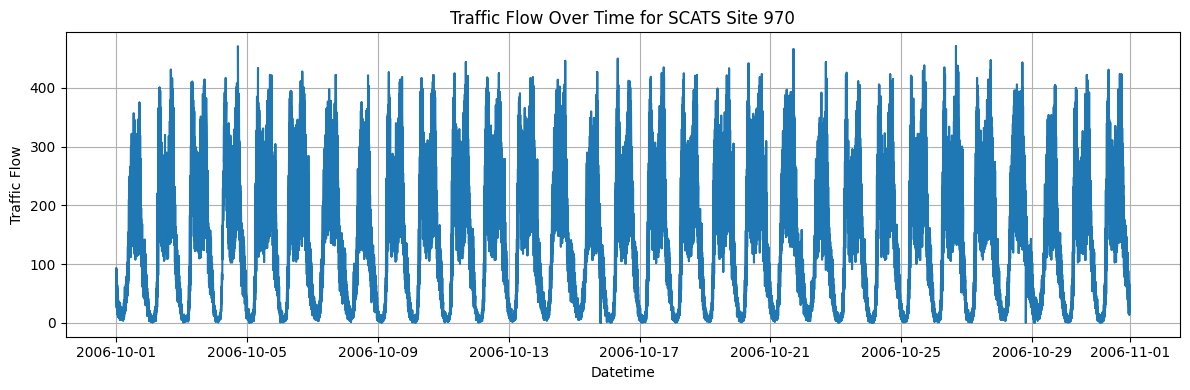

In [13]:
# Sample site visualization
sample_site = df_melted['SCATS Number'].unique()[0]
site_df = df_melted[df_melted['SCATS Number'] == sample_site]

plt.figure(figsize=(12, 4))
plt.plot(site_df['Datetime'], site_df['Traffic_flow'])
plt.title(f"Traffic Flow Over Time for SCATS Site {sample_site}")
plt.xlabel("Datetime")
plt.ylabel("Traffic Flow")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
import re

# Load raw file (with lat/lon + location)
df = pd.read_csv("../Data/Scats Data October 2006.csv", skiprows=1)

# Drop duplicates per site/location
site_df = df[['SCATS Number', 'Location', 'NB_LATITUDE', 'NB_LONGITUDE']].drop_duplicates()

def extract_main_road(loc):
    if not isinstance(loc, str):
        return None
    match = re.search(r"([A-Z_]+)_RD", loc)
    return match.group(1) if match else None

site_df['MainRoad'] = site_df['Location'].apply(extract_main_road)

# Save for graph construction
site_df.to_csv("../Data/scats_site_info.csv", index=False)
print("✅ Saved: scats_site_info.csv")

✅ Saved: scats_site_info.csv


In [17]:
import pickle

with open("../Graph/scats_graph_live.pkl", "rb") as f:
    G = pickle.load(f)

print("Available SCATS IDs:", list(G.nodes))


Available SCATS IDs: [970, 2000, 2200, 2825, 2827, 3001, 3002, 3120, 3122, 3126, 3127, 3180, 3662, 3682, 3685, 3804, 3812, 4030, 4032, 4034, 4035, 4040, 4043, 4051, 4057, 4063, 4262, 4263, 4264, 4266, 4270, 4272, 4273, 4321, 4324]


In [18]:
import pickle
import networkx as nx

with open("../Graph/scats_graph_live.pkl", "rb") as f:
    G = pickle.load(f)

# Pick a known node
start_id = 970

# Get all reachable nodes from this start node
reachable = nx.node_connected_component(G, start_id)
print("Nodes reachable from", start_id, ":", reachable)


Nodes reachable from 970 : {970}


In [19]:
# Example: pick another known SCATS
for node in G.nodes:
    reachable = nx.node_connected_component(G, node)
    if len(reachable) > 1:
        print(f"✅ Node {node} is connected to {len(reachable)} others: {reachable}")


✅ Node 2000 is connected to 2 others: {2000, 3685}
✅ Node 3001 is connected to 2 others: {3001, 3002}
✅ Node 3002 is connected to 2 others: {3001, 3002}
✅ Node 3120 is connected to 2 others: {3120, 4035}
✅ Node 3685 is connected to 2 others: {2000, 3685}
✅ Node 3804 is connected to 2 others: {3812, 3804}
✅ Node 3812 is connected to 2 others: {3804, 3812}
✅ Node 4035 is connected to 2 others: {3120, 4035}
